In [1]:
import pandas as pd
import datetime
import csv
import numpy as np
import os
import scipy as sp
import xgboost as xgb
import lightgbm as lgb
import itertools
import operator
import math
import warnings
warnings.filterwarnings("ignore")
from scipy import stats 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor
from sklearn.externals import joblib
from xgboost import plot_importance


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config ZMQInteractiveShell.ast_node_interactivity='all'
%pprint

# 大小设置
sns.set(rc={'figure.figsize':(13,7)})
# 风格设置
sns.set_style("whitegrid")

goal = 'target'


Pretty printing has been turned OFF


# 导入数据

In [2]:
df_train = pd.read_table('../data/zhengqi_train.txt', sep='\t')
df_train.head(2)

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V29,V30,V31,V32,V33,V34,V35,V36,V37,target
0,0.566,0.016,-0.143,0.407,0.452,-0.901,-1.812,-2.36,-0.436,-2.114,...,0.136,0.109,-0.615,0.327,-4.627,-4.789,-5.101,-2.608,-3.508,0.175
1,0.968,0.437,0.066,0.566,0.194,-0.893,-1.566,-2.36,0.332,-2.114,...,-0.128,0.124,0.032,0.600,-0.843,0.160,0.364,-0.335,-0.730,0.676


In [3]:
df_test = pd.read_table('../data/zhengqi_test.txt', sep='\t')
df_test.head(2)

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37
0,0.368,0.380,-0.225,-0.049,0.379,0.092,0.550,0.551,0.244,0.904,...,-0.449,0.047,0.057,-0.042,0.847,0.534,-0.009,-0.190,-0.567,0.388
1,0.148,0.489,-0.247,-0.049,0.122,-0.201,0.487,0.493,-0.127,0.904,...,-0.443,0.047,0.560,0.176,0.551,0.046,-0.220,0.008,-0.294,0.104


In [4]:
df_test["target"] = 0
df_train["isTrain"] = 1
df_test["isTrain"] = 0
dt = pd.concat([df_train, df_test], ignore_index=True)

# 加载数据

In [5]:
def load_data(dt=dt, m_type = 'xgb-model'):
    """
        加载数据，输出放入模型的特征features列表以及特征列表中是类别型的列表cate_feat
        对cate_feat进行了LabelEncoder，针对LGB增加category转化
    """
    # 参考资料：树模型LabelEncoder——https://www.cnblogs.com/ranjiewen/p/9105954.html:

    noise_feature = [goal, 'isTrain']
    category_feature = []
    numeric_feature = [i for i in dt.columns if i not in category_feature + noise_feature]
    
    lbl = LabelEncoder()  
    for col in category_feature:
        dt[col] = lbl.fit_transform(dt[col].astype(str))
    if m_type == 'lgb-model':
        for catf in category_feature:
            dt[catf] = dt[catf].astype('category')         
    features = numeric_feature + category_feature
    train = dt[dt.isTrain==1]
    test = dt[dt.isTrain==0]


    return (train, test, features, category_feature)

# 直接预测

- 第一次提交的xgb参数

LGB交叉验证...


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:502: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:794: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


[500]	cv_agg's rmse: 0.347536
[1000]	cv_agg's rmse: 0.339611
[1500]	cv_agg's rmse: 0.336547
[2000]	cv_agg's rmse: 0.335733
[2500]	cv_agg's rmse: 0.335043
[3000]	cv_agg's rmse: 0.334694


LGBMRegressor(bagging_fraction=0.6, bagging_freq=0, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, feature_fraction=0.8,
              importance_type='split', lambda_l1=1e-05, lambda_l2=1e-05,
              learning_rate=0.01, max_bin=85, max_depth=4, metrics='rmse',
              min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=31,
              min_split_gain=0, n_estimators=3184, n_jobs=-1, num_leaves=16,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, seed=2020002, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

LGB训练...


LGBMRegressor(bagging_fraction=0.6, bagging_freq=0, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, feature_fraction=0.8,
              importance_type='split', lambda_l1=1e-05, lambda_l2=1e-05,
              learning_rate=0.01, max_bin=85, max_depth=4, metrics='rmse',
              min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=31,
              min_split_gain=0, n_estimators=3184, n_jobs=-1, num_leaves=16,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, seed=2020002, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

训练集MSE： 0.030039377458799744
LGB迭代次数... 3184
LGB训练集预测...
LGB测试集预测...
XGB的特征重要性...


<Figure size 864x432 with 0 Axes>

Text(0.5,1,'Featurertances')

<Figure size 864x432 with 0 Axes>

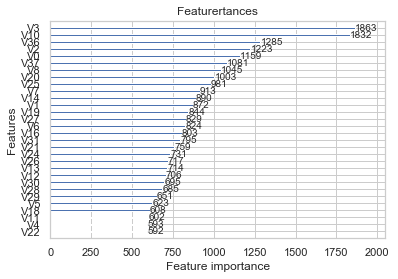

In [6]:
train, test, features, category_feature = load_data(dt=dt, m_type='xgb-model')

lgbRegr = LGBMRegressor(
boosting_type='gbdt',
                                                       objective='regression',
                                                       metrics='rmse',
                                                       learning_rate=0.01, 
                                                       n_estimators=8000, 
                                                       max_depth=4, 
                                                       num_leaves=16,
                                                       max_bin=85,
                                                       min_data_in_leaf=31,
                                                       bagging_fraction = 0.6,
                                                       feature_fraction = 0.8,
                                                       bagging_freq = 0,
                                                       lambda_l1=1e-05,
                                                       lambda_l2=1e-05,
                                                       min_split_gain=0,
    seed=2020002)
print('LGB交叉验证...')
lgb_param = lgbRegr.get_params()
    
dtrain = lgb.Dataset(dt.loc[dt.isTrain==1].iloc[:, 0:-2].values, dt.loc[dt.isTrain==1, goal].values)

cvresult = lgb.cv(lgb_param, 
                  dtrain,
                  num_boost_round=lgbRegr.get_params()['n_estimators'], 
                  nfold=3, 
                  metrics='rmse',
                  early_stopping_rounds=200, 
                  verbose_eval=500, 
                  show_stdv=False, 
                  seed=202002, 
                  callbacks=None, 
                  stratified=False,
                  shuffle=True)
lgbRegr.set_params(n_estimators=len(cvresult['rmse-mean']))
print('LGB训练...')
lgbRegr.fit(train[features], train[goal], eval_metric='rmse')
print('训练集MSE：', mean_squared_error(y_true=train[goal], y_pred=lgbRegr.predict(train[features])) )
print('LGB迭代次数...', lgbRegr.n_estimators)

print('LGB训练集预测...')
train_target_pre = lgbRegr.predict(train[features])

print('LGB测试集预测...')
test_target_pre = lgbRegr.predict(test[features])
#Plot feature importance 
print('XGB的特征重要性...')

plt.figure(figsize=(12,6))
lgb.plot_importance(lgbRegr, max_num_features=30)
plt.title("Featurertances")
plt.show()


# 去异常

In [7]:
def find_outlies(y_true, y_pre, train=train, sigma=3):
    diff = y_true-y_pre
    low_v = diff.quantile(sigma/100)
    up_v = diff.quantile(1-sigma/100)
    train = train[(diff>=low_v) & (diff<=up_v)]   
    return train

train = find_outlies(y_true=train.target, y_pre=train_target_pre, train=train, sigma=3)

# 调参

- 参考：https://www.twblogs.net/a/5be215942b717720b51cce01/zh-cn

In [8]:
train.shape

(2714, 40)

## 迭代轮数确认

In [11]:
X=train.iloc[:, 0:-2].values
y=train[goal].values
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=0,test_size=0.2)
params = {    
          'boosting_type': 'gbdt',
          'objective': 'regression',
          'metric': 'rmse',
          'nthread':4,
          'learning_rate':0.1,
          'num_leaves':30, 
          'max_depth': 5,   
          'subsample': 0.8, 
          'colsample_bytree': 0.8, 
    }
    
data_train = lgb.Dataset(X_train, y_train)
cv_results = lgb.cv(params, data_train, num_boost_round=5000, nfold=5, 
                    stratified=False, shuffle=True, 
                    metrics='rmse',
                    early_stopping_rounds=200,
                    seed=2020001)
print('best n_estimators:', len(cv_results['rmse-mean']))
print('best cv score:', pd.Series(cv_results['rmse-mean']).max())

best n_estimators: 444
best cv score: 0.8808646542491088


## max_depth与num_leaves

In [15]:
params_test1={'max_depth': [10, 11, 12, 13], 
              'num_leaves':[14, 15, 16]}
              
gsearch1 = GridSearchCV(estimator = LGBMRegressor(boosting_type='gbdt',
                                                       objective='regression',
                                                       metrics='rmse',
                                                       learning_rate=0.1, 
                                                       n_estimators=444, 
#                                                        max_depth=4, 
#                                                        num_leaves=30,
                                                       bagging_fraction = 0.8,
                                                       feature_fraction = 0.8), 
                       param_grid = params_test1, scoring='neg_mean_squared_error',cv=5,n_jobs=-1)
gsearch1.fit(X_train,y_train)
print("输出最优参数...")
gsearch1.best_params_
print("输出最优得分...")
gsearch1.best_score_

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LGBMRegressor(bagging_fraction=0.8, boosting_type='gbdt',
                                     class_weight=None, colsample_bytree=1.0,
                                     feature_fraction=0.8,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, metrics='rmse',
                                     min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=444, n_jobs=-1, num_leaves=31,
                                     objective='regression', random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=-1,
             param_grid={'max_

输出最优参数...


{'max_depth': 11, 'num_leaves': 15}

输出最优得分...


-0.06747983486394175

## max_bin与min_data_in_leaf

In [16]:
params_test2={'max_bin': range(70,90,3), 
              'min_data_in_leaf':range(25,40,3)}
              
gsearch1 = GridSearchCV(estimator = LGBMRegressor(boosting_type='gbdt',
                                                       objective='regression',
                                                       metrics='rmse',
                                                       learning_rate=0.1, 
                                                       n_estimators=444, 
                                                       max_depth=11, 
                                                       num_leaves=15,
                                                       bagging_fraction = 0.8,
                                                       feature_fraction = 0.8), 
                       param_grid = params_test2, scoring='neg_mean_squared_error',cv=5,n_jobs=-1)
gsearch1.fit(X_train,y_train)
print("输出最优参数...")
gsearch1.best_params_
print("输出最优得分...")
gsearch1.best_score_

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LGBMRegressor(bagging_fraction=0.8, boosting_type='gbdt',
                                     class_weight=None, colsample_bytree=1.0,
                                     feature_fraction=0.8,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=11, metrics='rmse',
                                     min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=444, n_jobs=-1, num_leaves=15,
                                     objective='regression', random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=-1,
             param_grid={'max_

输出最优参数...


{'max_bin': 76, 'min_data_in_leaf': 37}

输出最优得分...


-0.06645459839164501

## feature_fraction、bagging_fraction与bagging_freq

In [18]:
 params_test3={'feature_fraction': [0.6, 0.7, 0.8],
              'bagging_fraction': [0.85, 0.9, 0.95],
              'bagging_freq': range(4, 8, 1)
}
              
gsearch1 = GridSearchCV(estimator = LGBMRegressor(boosting_type='gbdt',
                                                       objective='regression',
                                                       metrics='rmse',
                                                       learning_rate=0.1, 
                                                       n_estimators=444, 
                                                       max_depth=11, 
                                                       num_leaves=15,
                                                       max_bin=76,
                                                       min_data_in_leaf=37,
#                                                        bagging_fraction = 0.8,
#                                                        feature_fraction = 0.8
                                                 ), 
                       param_grid = params_test3, scoring='neg_mean_squared_error',cv=5,n_jobs=-1)
gsearch1.fit(X_train,y_train)
print("输出最优参数...")
gsearch1.best_params_
print("输出最优得分...")
gsearch1.best_score_

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_bin=76, max_depth=11, metrics='rmse',
                                     min_child_samples=20,
                                     min_child_weight=0.001,
                                     min_data_in_leaf=37, min_split_gain=0.0,
                                     n_estimators=444, n_jobs=-1, num_leaves=15,
                                     objective='...n', random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=-1,
             param_grid={'bagging_fraction': [0

输出最优参数...


{'bagging_fraction': 0.9, 'bagging_freq': 4, 'feature_fraction': 0.7}

输出最优得分...


-0.06631312083568067

## lambda_l1与lambda_l2

In [19]:
params_test4={'lambda_l1': [1e-5,1e-3,1e-1,0.0,0.1,0.3,0.5,0.7,0.9,1.0],
              'lambda_l2': [1e-5,1e-3,1e-1,0.0,0.1,0.3,0.5,0.7,0.9,1.0]
}
              
gsearch1 = GridSearchCV(estimator = LGBMRegressor(boosting_type='gbdt',
                                                       objective='regression',
                                                       metrics='rmse',
                                                       learning_rate=0.1, 
                                                       n_estimators=444, 
                                                       max_depth=11, 
                                                       num_leaves=15,
                                                       max_bin=76,
                                                       min_data_in_leaf=37,
                                                       bagging_fraction = 0.9,
                                                       feature_fraction = 0.7,
                                                       bagging_freq = 4,
                                                 ), 
                       param_grid = params_test4, scoring='neg_mean_squared_error',cv=5,n_jobs=-1)
gsearch1.fit(X_train,y_train)
print("输出最优参数...")
gsearch1.best_params_
print("输出最优得分...")
gsearch1.best_score_

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LGBMRegressor(bagging_fraction=0.9, bagging_freq=4,
                                     boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0, feature_fraction=0.7,
                                     importance_type='split', learning_rate=0.1,
                                     max_bin=76, max_depth=11, metrics='rmse',
                                     min_child_samples=20,
                                     min_child_weight=0.001,
                                     min_data_in_leaf=37, min_split_gain...
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=-1,
             param_grid={'lambda_l1': [1e-05, 0.001, 0.1, 0.0, 0.1, 0.3, 0.5,
                             

输出最优参数...


{'lambda_l1': 0.001, 'lambda_l2': 0.7}

输出最优得分...


-0.06594850955883236

## min_split_gain

In [20]:
params_test5={'min_split_gain':[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]}
              
gsearch1 = GridSearchCV(estimator = LGBMRegressor(boosting_type='gbdt',
                                                       objective='regression',
                                                       metrics='rmse',
                                                       learning_rate=0.1, 
                                                       n_estimators=444, 
                                                       max_depth=11, 
                                                       num_leaves=15,
                                                       max_bin=76,
                                                       min_data_in_leaf=37,
                                                       bagging_fraction = 0.9,
                                                       feature_fraction = 0.7,
                                                       bagging_freq = 4,
                                                       lambda_l1=0.01,
                                                       lambda_l2=0.7
                                                 ), 
                       param_grid = params_test5, scoring='neg_mean_squared_error',cv=5,n_jobs=-1)
gsearch1.fit(X_train,y_train)
print("输出最优参数...")
gsearch1.best_params_
print("输出最优得分...")
gsearch1.best_score_

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LGBMRegressor(bagging_fraction=0.9, bagging_freq=4,
                                     boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0, feature_fraction=0.7,
                                     importance_type='split', lambda_l1=0.01,
                                     lambda_l2=0.7, learning_rate=0.1,
                                     max_bin=76, max_depth=11, metrics='rmse',
                                     min_child_samples=20,
                                     min_child_weight=0.001,
                                     min_d...
                                     n_estimators=444, n_jobs=-1, num_leaves=15,
                                     objective='regression', random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,


输出最优参数...


{'min_split_gain': 0.0}

输出最优得分...


-0.06725417569636875

# 分析与预测

LGB交叉验证...


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:502: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:794: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


[500]	cv_agg's rmse: 0.340906
[1000]	cv_agg's rmse: 0.332952
[1500]	cv_agg's rmse: 0.330916
[2000]	cv_agg's rmse: 0.330007
[2500]	cv_agg's rmse: 0.329539
[3000]	cv_agg's rmse: 0.329192
[3500]	cv_agg's rmse: 0.329103


LGBMRegressor(bagging_fraction=0.9, bagging_freq=4, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, feature_fraction=0.7,
              importance_type='split', lambda_l1=0.01, lambda_l2=0.7,
              learning_rate=0.01, max_bin=76, max_depth=11, metrics='rmse',
              min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=37,
              min_split_gain=0, n_estimators=3416, n_jobs=-1, num_leaves=15,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, seed=2020002, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

LGB训练...


LGBMRegressor(bagging_fraction=0.9, bagging_freq=4, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, feature_fraction=0.7,
              importance_type='split', lambda_l1=0.01, lambda_l2=0.7,
              learning_rate=0.01, max_bin=76, max_depth=11, metrics='rmse',
              min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=37,
              min_split_gain=0, n_estimators=3416, n_jobs=-1, num_leaves=15,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, seed=2020002, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

训练集MSE： 0.014218697485650723
LGB迭代次数... 3416
LGB训练集预测...
LGB测试集预测...
LGB的特征重要性...


<Figure size 864x432 with 0 Axes>

Text(0.5,1,'Featurertances')

<Figure size 864x432 with 0 Axes>

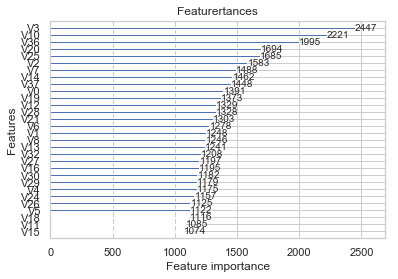

In [21]:
train, test, features, category_feature = load_data(dt=dt, m_type='xgb-model')

lgbRegr = LGBMRegressor(
boosting_type='gbdt',
                                                       objective='regression',
                                                       metrics='rmse',
                                                       learning_rate=0.01, 
                                                       n_estimators=8000, 
                                                       max_depth=11, 
                                                       num_leaves=15,
                                                       max_bin=76,
                                                       min_data_in_leaf=37,
                                                       bagging_fraction = 0.9,
                                                       feature_fraction = 0.7,
                                                       bagging_freq = 4,
                                                       lambda_l1=0.01,
                                                       lambda_l2=0.7,
                                                       min_split_gain=0,
    seed=2020002)
print('LGB交叉验证...')
lgb_param = lgbRegr.get_params()
    
dtrain = lgb.Dataset(dt.loc[dt.isTrain==1].iloc[:, 0:-2].values, dt.loc[dt.isTrain==1, goal].values)

cvresult = lgb.cv(lgb_param, 
                  dtrain,
                  num_boost_round=lgbRegr.get_params()['n_estimators'], 
                  nfold=3, 
                  metrics='rmse',
                  early_stopping_rounds=200, 
                  verbose_eval=500, 
                  show_stdv=False, 
                  seed=202002, 
                  callbacks=None, 
                  stratified=False,
                  shuffle=True)
lgbRegr.set_params(n_estimators=len(cvresult['rmse-mean']))
print('LGB训练...')
lgbRegr.fit(train[features], train[goal], eval_metric='rmse')
print('训练集MSE：', mean_squared_error(y_true=train[goal], y_pred=lgbRegr.predict(train[features])) )
print('LGB迭代次数...', lgbRegr.n_estimators)

print('LGB训练集预测...')
train_target_pre = lgbRegr.predict(train[features])

print('LGB测试集预测...')
test_target_pre = lgbRegr.predict(test[features])

#Plot feature importance 
print('LGB的特征重要性...')

plt.figure(figsize=(12,6))
lgb.plot_importance(lgbRegr, max_num_features=30)
plt.title("Featurertances")
plt.show()

# 去异常后与真实值对比

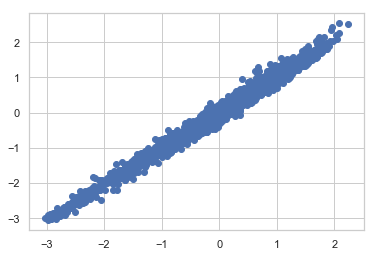

In [22]:
plt.scatter(train_target_pre, train.target)

# 保存结果

In [23]:
submission2 = pd.DataFrame({goal: test_target_pre})
submission2.to_csv("../result/sample_submit05-xxx-lgb-delOutlies.txt", sep='\t', index=False, header=False)

# 去异常的xgb与lgb融合

In [24]:
submission1 = pd.read_table('../result/sample_submit04-1328-xgb-delOutlies.txt', sep='\t', header=None, names=None, index_col=None)
submission1.columns = [goal]


In [25]:
submission3 = pd.DataFrame({goal: (1/3*submission2.target.values + 2/3*submission1.target.values ) })
submission3.to_csv("../result/sample_submit06-xxxx-2_3xgb_delOutlies-1_3lgbm_delOutlies.txt", sep='\t', index=False, header=False)